In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
cutoffs_df = pd.read_csv("cutoffs.csv")

In [3]:
cutoffs_df.head()

,college_code,college_name,branch_code,branch_name,category,year,round,percentile
0,C44B5EC,Veermata Jijabai Technological Institute(VJTI)...,B2A7BD2,Computer Engineering,TFWS,2022,1,99.843394
1,C44B5EC,Veermata Jijabai Technological Institute(VJTI)...,B2A7BD2,Computer Engineering,OPEN,2022,1,99.829843
2,C44B5EC,Veermata Jijabai Technological Institute(VJTI)...,B2A7BD2,Computer Engineering,OPEN,2022,1,99.817615
3,CA95211,COEP Technological University,B2A7BD2,Computer Engineering,NT3,2022,1,99.803612
4,CA95211,COEP Technological University,B2A7BD2,Computer Engineering,LNT2,2022,1,99.787304


In [4]:
cutoffs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28377 entries, 0 to 28376
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   college_code  28377 non-null  object 
 1   college_name  28377 non-null  object 
 2   branch_code   28377 non-null  object 
 3   branch_name   28377 non-null  object 
 4   category      28377 non-null  object 
 5   year          28377 non-null  int64  
 6   round         28377 non-null  int64  
 7   percentile    28377 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 1.7+ MB


In [5]:
cutoffs_df.isnull().sum()

college_code    0
college_name    0
branch_code     0
branch_name     0
category        0
year            0
round           0
percentile      0
dtype: int64

In [6]:
cutoffs_df = cutoffs_df.rename(
    columns={"percentile": "cutoff_percentile"}
)

In [7]:
cutoffs_df["cutoff_percentile"].describe()

count    28377.000000
mean        52.102999
std         28.700460
min          0.004739
25%         26.900779
50%         55.218152
75%         76.990020
max         99.843394
Name: cutoff_percentile, dtype: float64

In [8]:
cutoffs_df["category"].value_counts()

category
OPEN       7671
OBC        3907
SC         3333
ST         2588
AI         1560
EWS        1239
TFWS       1082
NT1H        794
NT2H        776
GVJH        706
NT3H        689
ORPHAN      523
NT2O        468
GVJO        358
MI          245
NT1O        244
NT2         216
MI-MH       216
NT1         213
GVJS        207
NT3         205
LNT2        177
LNT2H       158
LVJS        153
NT3O        144
LNT1        122
LVJH        112
LNT3         77
LNT1H        73
MI-AI        35
LNT3H        25
DEFRNT2      16
LNT2O        13
DEFRNT3       8
LVJO          6
LNT1O         5
DEFRNT1       3
LNT3O         3
PWDRNT1       2
PWDRVJS       2
PWDRNT2       2
PWDRNT3       1
Name: count, dtype: int64

In [9]:
def map_category(cat):
    open_group = ["OPEN", "AI", "MI", "MI-MH", "MI-AI"]
    obc_group = ["OBC", "EWS"]
    sc_group = ["SC"]
    st_group = ["ST"]

    if cat in open_group:
        return "OPEN"
    elif cat in obc_group:
        return "OBC_EWS"
    elif cat in sc_group:
        return "SC"
    elif cat in st_group:
        return "ST"
    elif cat.startswith(("NT", "GVJ", "LVJ", "LNT")):
        return "NT_VJ"
    else:
        return "SPECIAL"

In [10]:
cutoffs_df["ml_category"] = cutoffs_df["category"].apply(map_category)

cutoffs_df["ml_category"].value_counts()

ml_category
OPEN       9727
NT_VJ      5944
OBC_EWS    5146
SC         3333
ST         2588
SPECIAL    1639
Name: count, dtype: int64

In [11]:
rows = []

for _, row in cutoffs_df.iterrows():
    cutoff = row["cutoff_percentile"]
    ml_cat = row["ml_category"]
    round_ = row["round"]

    for student_percentile in np.arange(cutoff - 10, cutoff + 10.5, 0.5):
        rows.append({
            "student_percentile": student_percentile,
            "cutoff_percentile": cutoff,
            "diff": student_percentile - cutoff,
            "ml_category": ml_cat,
            "round": round_,
            "admitted": 1 if student_percentile >= cutoff else 0
        })

ml_df = pd.DataFrame(rows)

In [12]:
ml_df.shape

(1164898, 6)

In [13]:
ml_df["admitted"].value_counts(normalize=True)

admitted
1    0.512459
0    0.487541
Name: proportion, dtype: float64

In [14]:
ml_df["diff"].describe()

count    1.164898e+06
mean     1.298869e-02
std      5.923930e+00
min     -1.000000e+01
25%     -5.000000e+00
50%      0.000000e+00
75%      5.000000e+00
max      1.050000e+01
Name: diff, dtype: float64

In [15]:
ml_df.to_csv(
    "admission_probability_training_v1.csv",
    index=False
)

In [16]:
ml_df = pd.read_csv("admission_probability_training_v1.csv")
ml_df.head()

,student_percentile,cutoff_percentile,diff,ml_category,round,admitted
0,89.843394,99.843394,-10.0,SPECIAL,1,0
1,90.343394,99.843394,-9.5,SPECIAL,1,0
2,90.843394,99.843394,-9.0,SPECIAL,1,0
3,91.343394,99.843394,-8.5,SPECIAL,1,0
4,91.843394,99.843394,-8.0,SPECIAL,1,0


In [17]:
X = ml_df[
    [
        "student_percentile",
        "cutoff_percentile",
        "diff",
        "ml_category",
        "round"
    ]
]

y = ml_df["admitted"]

In [18]:
X = pd.get_dummies(
    X,
    columns=["ml_category", "round"],
    drop_first=True
)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [20]:
model = LogisticRegression(
    max_iter=1000
)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [21]:
y_probs = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, y_probs)

np.float64(0.9999993451310853)

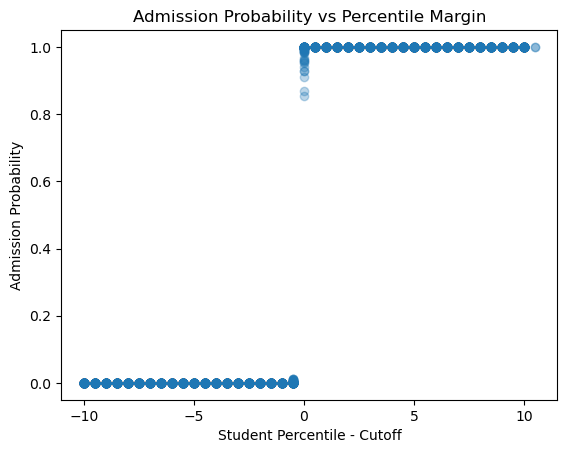

In [22]:
sample = ml_df.sample(3000, random_state=42)

sample_X = pd.get_dummies(
    sample[
        [
            "student_percentile",
            "cutoff_percentile",
            "diff",
            "ml_category",
            "round"
        ]
    ],
    columns=["ml_category", "round"],
    drop_first=True
)

sample_X = sample_X.reindex(columns=X.columns, fill_value=0)

sample["predicted_probability"] = model.predict_proba(sample_X)[:, 1]

plt.scatter(sample["diff"], sample["predicted_probability"], alpha=0.3)
plt.xlabel("Student Percentile - Cutoff")
plt.ylabel("Admission Probability")
plt.title("Admission Probability vs Percentile Margin")
plt.show()